# Simple Stock Price Prediction Model

Created by Marc Zeugin

### Import modules

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from get_stock_data import get_stock_data
from nn_models import lstm_prediction
from models import predict_regression
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from forecast import user_input
plt.style.use('seaborn-whitegrid')
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import math

### Set options

In [2]:
models = ['LR', 'RF', 'RCV', 'MLP', 'LLCV', 'PAR'] # available options are LR (LinearRegression), RF (RandomForestRegressor), SVM (SupportVectorRegressor), 
# GBR (GradientBoostingRegressor), ABR (AdaBoostRegressor), GPR (GaussianProcessRegressor), RCV (RidgeCV), LLCV (LassoLarsCV), BR (BayesianRidge), 
# KNN (KNeighborsRegressor), LCV (LassoCV), MLP (MLPRegressor), LSVM (LinearSupportVectorRegressor), ET (ExtraTreeRegressor) LRCV (LogisticRegressionCV), 
# PR (PoissonRegressor), PAR (PassiveAggressiveRegressor)
# period = '10y' # available options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
training_data_split = 0.8 # as a decimal
shift = 2 # in days
new_stocks = [] # add strings of symbols of new stocks to include
start_date = "2017-01-01" # start date of stock data
end_date = "2021-12-29" # end date of stock data

### Load financial data from yahoo finance API or local folder if available

In [3]:
ticker_hist_list, tickers = get_stock_data(new_stocks, start_date, end_date)

### Display all stock closing price plots

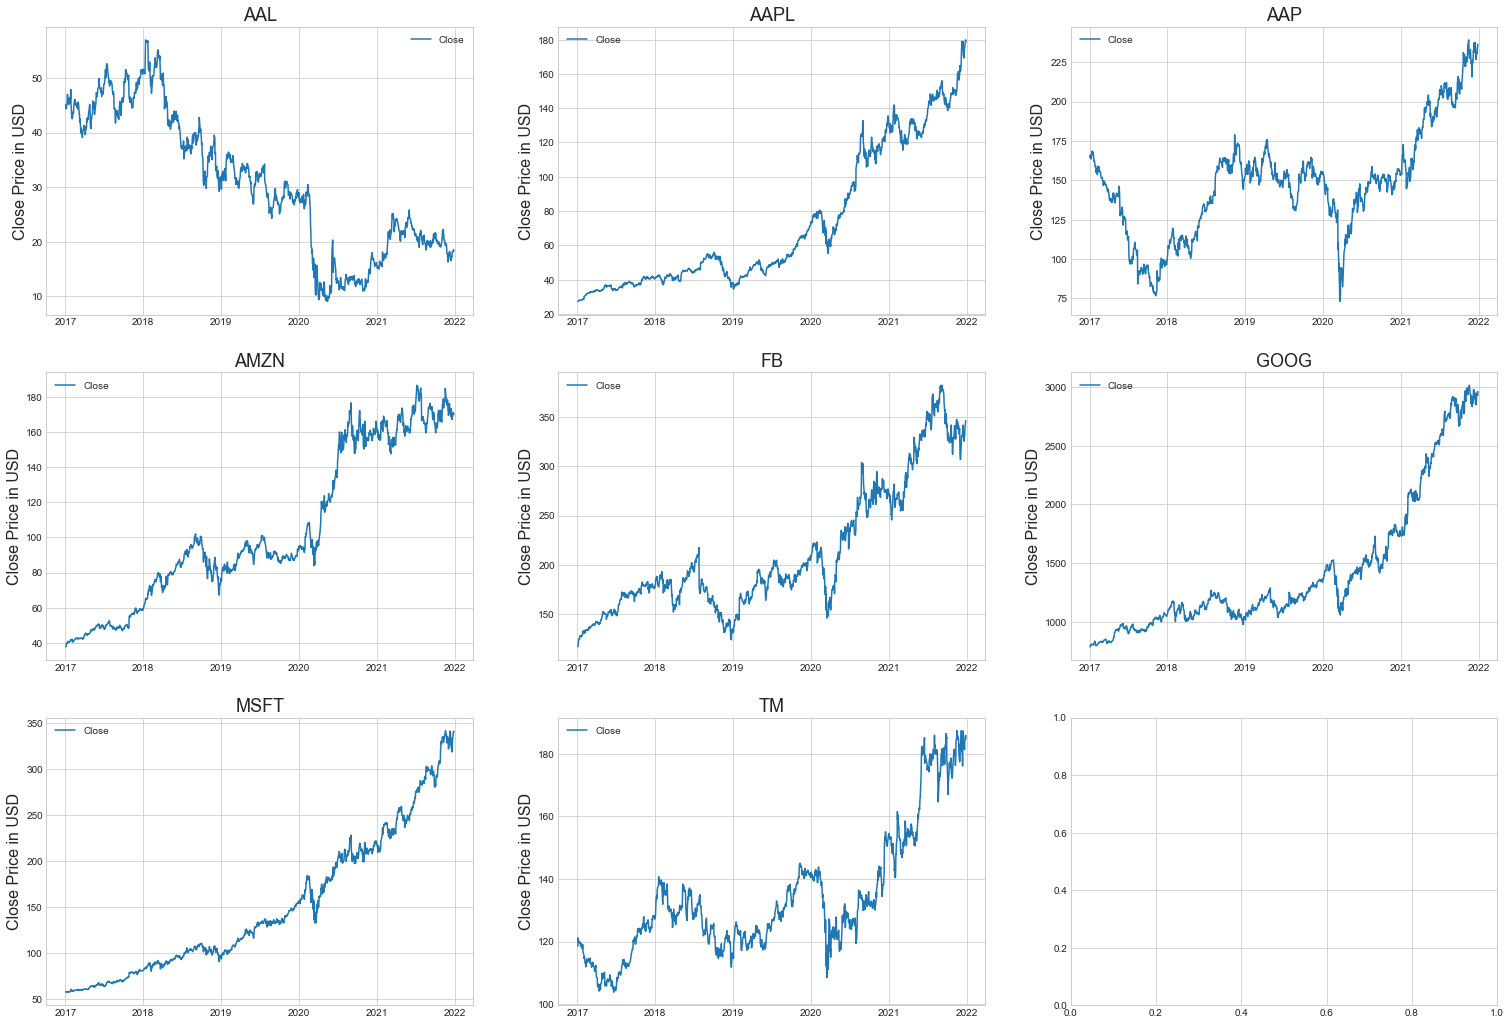

In [4]:
rows = int(math.ceil(len(tickers)/3))
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(26, 6*rows))

if rows == 1:
    for col in range(cols):
        ax[col].set_title(tickers[col], fontsize=18)
        ax[col].plot(ticker_hist_list[col]['Close'], label='Close')
        ax[col].legend(loc='best')
        ax[col].set_ylabel('Close Price in USD', fontsize=16)
else:
    for row in range(rows):
        for col in range(cols):
            if col + cols*row < len(tickers):
                ax[row, col].set_title(tickers[col + cols*row], fontsize=18)
                ax[row, col].plot(ticker_hist_list[col + cols*row]['Close'], label='Close')
                ax[row, col].legend(loc='best')
                ax[row, col].set_ylabel('Close Price in USD', fontsize=16)
plt.show()

### Create one dataset with all stock data

In [5]:
stock_data = pd.concat(ticker_hist_list, axis=1)
col_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
stock_data.columns = [col_name + '.' + ticker for ticker in tickers for col_name in col_names]
stock_data.index.name = 'Date'
print(stock_data.shape)

(1256, 56)


In [6]:
stock_data.describe()

,Open.AAL,High.AAL,Low.AAL,Close.AAL,Volume.AAL,Dividends.AAL,Stock Splits.AAL,Open.AAPL,High.AAPL,Low.AAPL,...,Volume.MSFT,Dividends.MSFT,Stock Splits.MSFT,Open.TM,High.TM,Low.TM,Close.TM,Volume.TM,Dividends.TM,Stock Splits.TM
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1256.000000,1256.0,1256.000000,1256.000000,1256.000000,...,1.256000e+03,1256.000000,1256.0,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1256.0,1256.0
mean,30.886633,31.383096,30.349468,30.834485,2.531278e+07,0.001035,0.0,73.032830,73.835990,72.272701,...,2.849454e+07,0.007635,0.0,134.252914,134.846759,133.559172,134.219960,2.096187e+05,0.0,0.0
std,12.750909,12.820574,12.697936,12.764692,3.511586e+07,0.010125,0.0,40.741940,41.241965,40.248610,...,1.271241e+07,0.060636,0.0,20.214220,20.343918,20.079750,20.240930,1.130391e+05,0.0,0.0
min,8.770000,9.190000,8.250000,9.040000,1.352400e+06,0.000000,0.0,27.175512,27.299890,26.931449,...,7.425600e+06,0.000000,0.0,104.500000,104.550003,103.620003,103.820000,4.840000e+04,0.0,0.0
25%,19.970000,20.367501,19.530001,19.930000,5.465725e+06,0.000000,0.0,41.266033,41.620005,41.011019,...,2.028538e+07,0.000000,0.0,120.702499,121.382500,120.132500,120.869997,1.336250e+05,0.0,0.0
50%,30.608047,31.103882,30.120087,30.574699,8.588900e+06,0.000000,0.0,52.301706,52.978233,51.771088,...,2.510025e+07,0.000000,0.0,129.089996,129.544998,128.380005,129.070007,1.800500e+05,0.0,0.0
75%,42.492251,42.998496,41.923044,42.518808,3.555038e+07,0.000000,0.0,114.527785,115.949965,112.834452,...,3.266678e+07,0.000000,0.0,141.330002,141.807503,140.620003,141.287498,2.551500e+05,0.0,0.0
max,57.300620,57.583274,56.335700,56.988728,4.286171e+08,0.100000,0.0,180.624141,181.631386,178.041235,...,1.112421e+08,0.620000,0.0,187.869995,188.949997,187.139999,187.440002,1.415500e+06,0.0,0.0


### Load macro dataset

In [7]:
macro_data = pd.read_excel("Macrodata.xlsx", index_col=0)
macro_data = macro_data.fillna(0)
print(macro_data.shape)

(4531, 50)


In [8]:
macro_data.describe()

,10y_Inflation,5y_Inflation,10y_Treasury,2y_Treasury,5y_Treasury,TED_Spread,AAA_Bond_Yield,BAA_Bond_Yield,Unemployment,Unemployment_Black,...,New_Cons_Durable_Goods,Industrial_Production_Total,Nonfarm_Total,Debt_to_GDP,GDP,Gov_Expend_Total,Income_per_Capita,GDP_Per_Capita,Median_House_Price,Nonfarm_Payrolls_Total
count,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,...,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000
mean,0.020543,0.018615,0.028493,0.015907,0.021960,0.005027,-0.000073,-0.000073,0.004474,0.003026,...,0.004580,0.000581,0.000674,0.011822,0.010128,0.012493,0.009086,0.002947,0.010757,0.002051
std,0.004165,0.005719,0.011431,0.014634,0.012675,0.082806,0.013821,0.009844,0.130800,0.086401,...,0.079545,0.011393,0.008180,0.003015,0.013549,0.051954,0.014897,0.011787,0.024940,0.012439
min,0.000400,-0.022400,0.005200,0.000900,0.001900,-0.400000,-0.133500,-0.043600,-0.169200,-0.167200,...,-0.553100,-0.135900,-0.135700,0.006900,-0.093300,-0.143200,-0.055000,-0.089800,-0.062708,-0.107300
25%,0.017950,0.015700,0.019700,0.004100,0.012900,-0.043500,-0.007900,-0.006200,-0.018625,-0.029753,...,-0.015447,-0.001702,0.000674,0.009688,0.007630,0.002284,0.005315,0.001271,-0.005822,0.001915
50%,0.021400,0.018800,0.026500,0.009400,0.018300,0.004471,-0.001800,-0.001500,-0.005239,-0.003914,...,0.001700,0.001381,0.001286,0.010300,0.010611,0.010215,0.009408,0.003828,0.011262,0.003640
75%,0.023600,0.022600,0.038300,0.025100,0.029600,0.047600,0.007500,0.005800,0.007647,0.024631,...,0.020240,0.004384,0.001800,0.015934,0.014124,0.014423,0.013169,0.006288,0.025684,0.005300
max,0.027600,0.031700,0.052600,0.052900,0.052300,1.533300,0.180600,0.106400,2.215400,1.319000,...,1.031600,0.062000,0.033800,0.016900,0.085300,0.460400,0.117109,0.075000,0.077017,0.057900


### Adjust macrodata to stockdata size

In [9]:
macro_data = macro_data.drop(macro_data.index[:-stock_data.shape[0]-2])
macro_data = macro_data.drop(macro_data.index[-2:])
print(macro_data.shape)

(1256, 50)


In [10]:
#check if start and end date are the same
print(stock_data.head(2).index)
print(stock_data.tail(2).index)
print(macro_data.head(2).index)
print(macro_data.tail(2).index)

DatetimeIndex(['2017-01-03', '2017-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-12-27', '2021-12-28'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2017-01-03', '2017-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-12-27', '2021-12-28'], dtype='datetime64[ns]', name='Date', freq=None)


### Pull macroeconomic data from API

### Add macroeconomic data to dataset

In [11]:
all_data = pd.concat([stock_data, macro_data], axis=1)
print(all_data.shape)

(1256, 106)


### Add lagged features to the dataset

In [12]:
for col in all_data:
    for i in range(1, shift):
        all_data[col + str(-i)] = all_data[col].shift(i)

In [13]:
#remove first i instances because of NaN from shifting
for i in range(1, shift):
    all_data.drop(index=all_data.index[0], axis=0, inplace=True)

### Split into train and test

In [14]:
colum_name = f'Close.{"AAP"}'

X = all_data.copy()
X = X.drop(columns=[colum_name])
y = all_data[colum_name].copy()

print(f'X shape: {X.shape} & y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=False)

print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} & y_test shape: {y_test.shape}')

X shape: (1255, 211) & y shape: (1255,)
X_train shape: (1004, 211) & X_test shape: (251, 211)
y_train shape: (1004,) & y_test shape: (251,)


### Apply MinMaxScaler to dataset

In [15]:
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.fit_transform(y_test.values.reshape(-1, 1))
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')

X_train shape: (1004, 211) & X_test shape: (251, 211)
X_train shape: (1004, 211) & X_test shape: (251, 211)


### Reshape input for LSTM model to match requirements

In [16]:
X_train_nn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_nn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f'X_train_nn shape: {X_train_nn.shape} & X_test_nn shape: {X_test_nn.shape}')
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
print(f'y_train_nn shape: {y_train.shape} & y_test_nn shape: {y_test.shape}')

X_train_nn shape: (1004, 211, 1) & X_test_nn shape: (251, 211, 1)
y_train_nn shape: (1004, 1) & y_test_nn shape: (251, 1)


### Fit LSTM model

In [17]:
history, test_predict = lstm_prediction(X_train_nn, y_train_nn, X_test_nn, y_test_nn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 211, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 211, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 211, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 211, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 1

dict_keys(['loss', 'val_loss'])


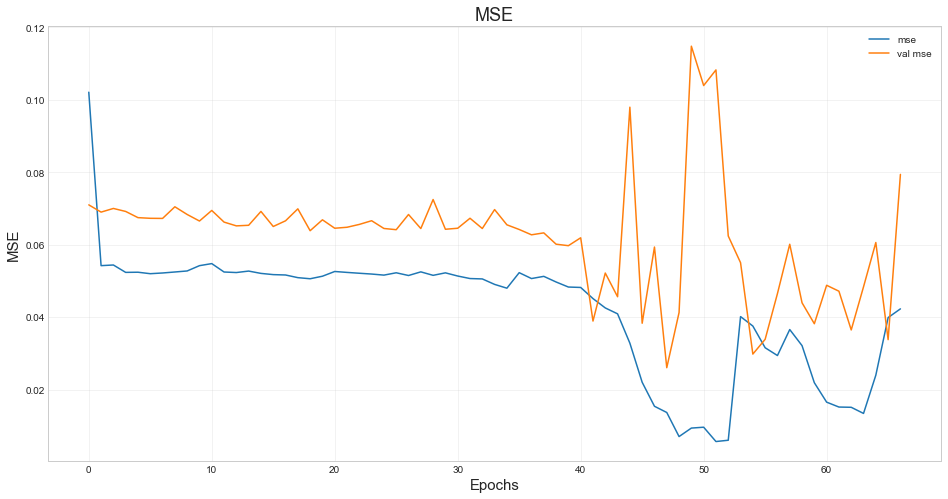

In [18]:
print(history.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history.epoch, history.history['loss'], label = "mse")
plt.plot(history.epoch, history.history['val_loss'], label = "val mse")
plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Calculate RMSE and MAE

In [19]:
print(f'RMSE: {math.sqrt(mean_squared_error(y_test, test_predict))}')
print(f'MSE: {mean_squared_error(y_test, test_predict)}')
print(f'MAE: {mean_absolute_error(y_test, test_predict)}')

RMSE: 0.28183193380305843
MSE: 0.0794292389111715
MAE: 0.23909351983036592


### Plot prediction vs actual close price

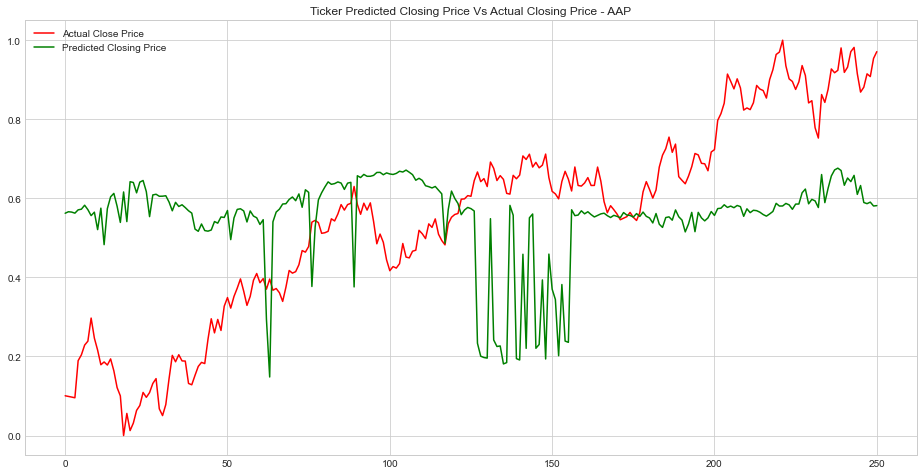

In [20]:
plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price - {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Inverse predictions

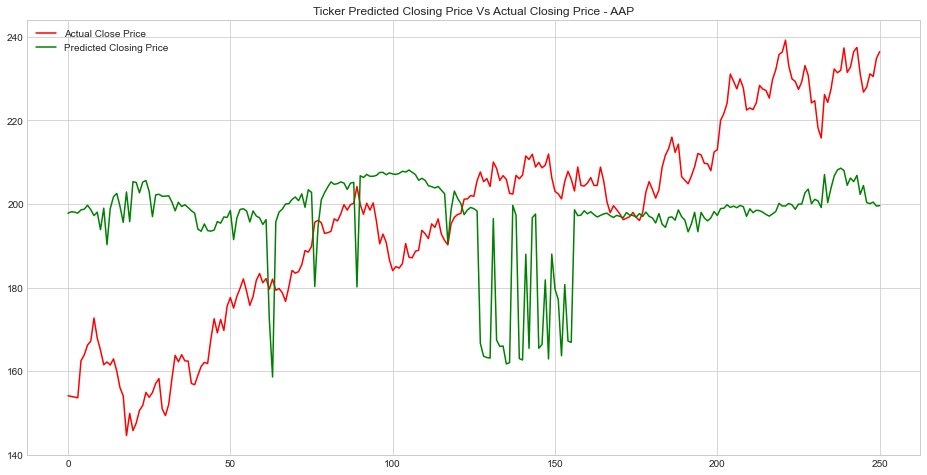

In [21]:
y_test = scaler_y.inverse_transform(y_test)
test_predict = scaler_y.inverse_transform(test_predict)

plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price - {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Preparation for non-NN Models

In [22]:
X = stock_data.drop([f'Close.{"AAP"}'], axis=1)
y = stock_data[f'Close.{"AAP"}']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=True)
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
print(f'Training sample size: {X_train.shape[0]} and testing sample size: {X_test.shape[0]}.')

Training sample size: 1004 and testing sample size: 252.


### Apply MinMaxScaler to dataset

In [23]:
scaler_x2 = MinMaxScaler()
scaler_y2 = MinMaxScaler()
X_train = scaler_x2.fit_transform(X_train)
X_test = scaler_x2.fit_transform(X_test)
y_train = scaler_y2.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y2.fit_transform(y_test.values.reshape(-1, 1))

### Prediction with Logistic Regression

In [24]:
y_pred = predict_regression(models, X_train, y_train, X_test)

done with LR
done with RF
done with RCV
done with MLP
done with LLCV
done with PAR


In [25]:
x = PrettyTable()
x.field_names = ["Model", "R2 Score", 'RMSE', 'MAE']

for key, value in y_pred.items():
    x.add_row([key, round(r2_score(y_test, value), 4), round(math.sqrt(mean_squared_error(y_test, value)), 4), round(mean_absolute_error(y_test, value), 4)])

print(x)

+-------+----------+--------+--------+
| Model | R2 Score |  RMSE  |  MAE   |
+-------+----------+--------+--------+
|   LR  |  0.9987  | 0.0075 | 0.0059 |
|   RF  |  0.9976  | 0.0105 | 0.0082 |
|  RCV  |  0.9978  | 0.0099 | 0.0078 |
|  MLP  |  0.9752  | 0.0334 | 0.0255 |
|  LLCV |  0.9989  | 0.0072 | 0.0057 |
|  PAR  |  0.9399  | 0.052  | 0.0444 |
+-------+----------+--------+--------+


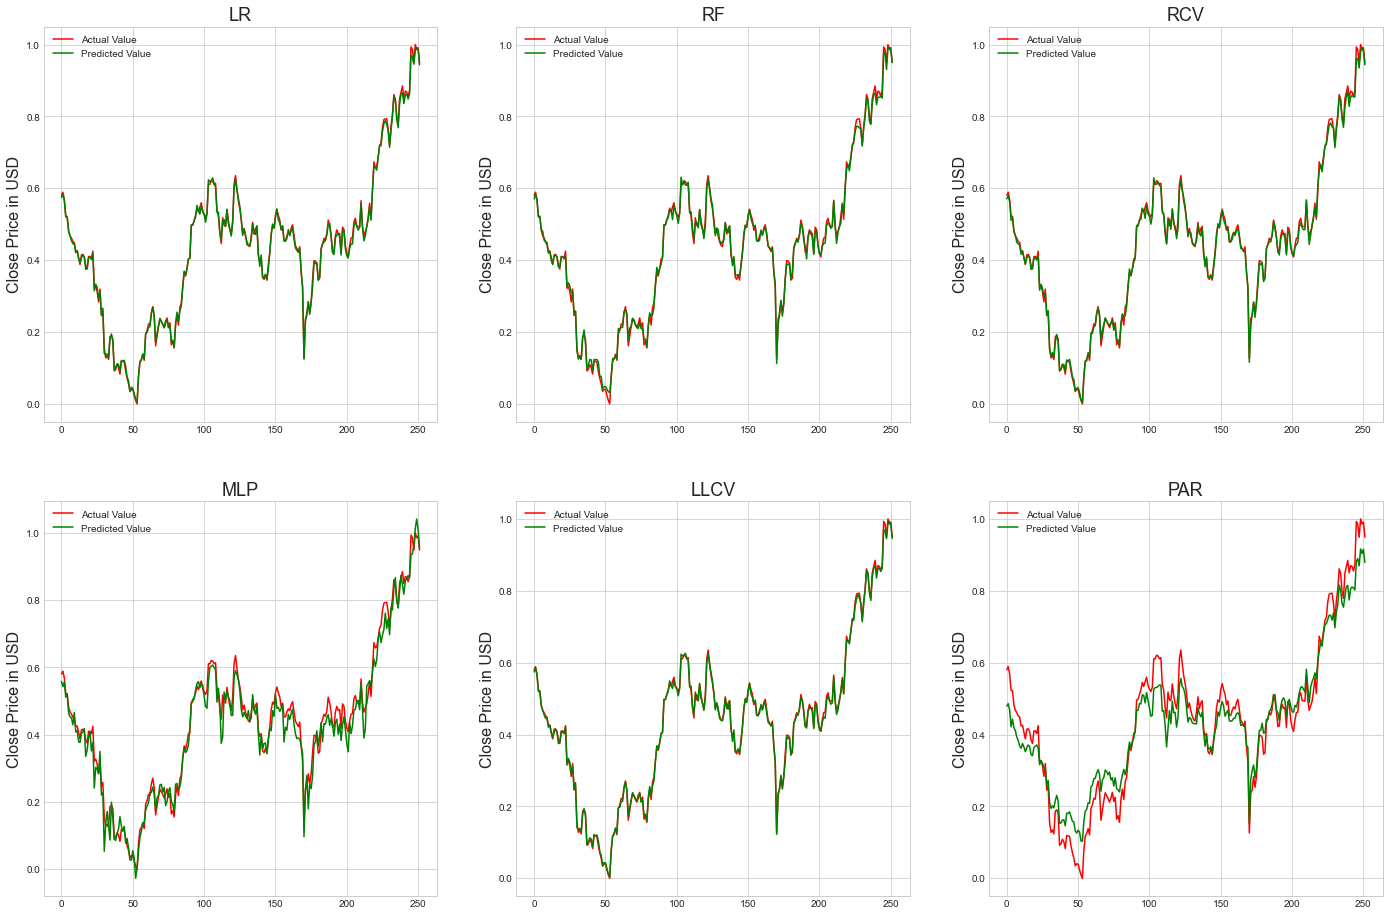

In [26]:
rows = int(math.ceil(len(models)/3))
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(24, 8*rows))

if rows == 1:
    for col in range(cols):
        ax[col].set_title(models[col], fontsize=18)
        ax[col].plot(y_test, color='red', label='Actual Value')
        ax[col].plot(y_pred[models[col]], color='green', label='Predicted Value')
        ax[col].legend(loc='best')
        ax[col].set_ylabel('Close Price in USD', fontsize=16)
else:
    for row in range(rows):
        for col in range(cols):
            if col + cols*row < len(models):
                ax[row, col].set_title(models[col + cols*row], fontsize=18)
                ax[row, col].plot(y_test, color='red', label='Actual Value')
                ax[row, col].plot(y_pred[models[col + cols*row]], color='green', label='Predicted Value')
                ax[row, col].legend(loc='best')
                ax[row, col].set_ylabel('Close Price in USD', fontsize=16)
plt.show()

### Function to predict user selected stock performance

In [27]:
user_input()

['MSFT']

# TODO

* Macrodata via API call
* Add more models
* Add hyperparameter tuning
* Add crossvalidation
* Add actual forecast